# Pipeline Counts

Frank Aragona  
February 27, 2024

# Libraries

And read in custom functions

In [ ]:
options(box.path = getwd())
getwd()


[1] "C:/Users/FAA3303/Projects/sequencing1.0_sanitized/docs/notebooks"

Registered S3 methods overwritten by 'readr':
  method                    from 
  as.data.frame.spec_tbl_df vroom
  as_tibble.spec_tbl_df     vroom
  format.col_spec           vroom
  print.col_spec            vroom
  print.collector           vroom
  print.date_names          vroom
  print.locale              vroom
  str.col_spec              vroom

# Get Data

In [ ]:
# ------ Read in all tables and get counts ------ #


#' @export
#' match in wdrs or keep_na
#' 
#' @description
#' Find a match in WDRS or Keep_NA and assign it a new column. Used to get counts and filter
#' 
#' @param df a dataframe
match_in_wdrs_keep_na <- function(df){
  df %>%
    mutate(in_wdrs = case_when(
      SEQUENCE_CLINICAL_ACCESSION %in% 
        na.omit(wdrs_seq$SEQUENCE_CLINICAL_ACCESSION_NUMBER) |
        
        SEQUENCE_ACCESSION %in% 
        na.omit(wdrs_seq$SEQUENCE_GISAID_STRAIN) ~ 1,
      TRUE ~ 0
    )) %>%
    mutate(in_keep_na = case_when(
      SEQUENCE_CLINICAL_ACCESSION %in% 
        na.omit(keep_na2$SEQUENCE_CLINICAL_ACCESSION) |
        
        SEQUENCE_ACCESSION %in% 
        na.omit(keep_na2$SEQUENCE_ACCESSION) ~ 1,
      TRUE ~ 0
    ))
}

# Read in keep_na - this reads in the saved keep_na pin
keep_na <- read_csv(file.path(here::here(),"docs/notebooks/data/keep_na.csv"))


New names:
• `` -> `...1`

e.g.:
  dat <- vroom(...)
  problems(dat)

Rows: 19855 Columns: 137
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (22): file_name, SEQUENCE_SPECIMEN, SEQUENCE_REASON, SEQUENCE_LAB, SEQU...
dbl   (3): ...1, CASE_ID, GISAID_ID_YEAR
lgl (112): SEQUENCE_SGTF, SEQUENCE_DATE, Virus name, Accession ID, Collectio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

# Count Summary

In [ ]:
# ------ Create Final Table of Counts ------ #

# Get the Counts
pipeline_counts <- tribble(
  ~Location, ~Count,
  "For Review", for_review_count,
  "Fuzzy Review", fuzzy_count,
  "Keep NA", keep_na_count,
  "WDRS", wdrs_count) %>%
  # Get the Percents
  mutate(freq = scales::label_percent()(Count / sum(Count))) %>%
  # Get the Totals
  janitor::adorn_totals()

# Take the counts and put them in a table.

# use the gt table for html stuff
  # Convert to a GT table and style it
(gt_counts <- pipeline_counts %>%
  gt() %>%
  cols_merge_n_pct(
    col_n = Count,
    col_pct = freq
  ) %>%
  fmt_number(
    columns = Count,
    decimals = 0,
    use_seps = T
  ) %>%
  # Highlight the WDRS row
  gt_highlight_rows(
     rows = Location == "WDRS",
     fill = "#8b7d7b",
     bold_target_only = TRUE,
     target_col = Count
   ) %>%
  cols_align("left") %>%
  tab_header(title = 
               md("Covid Sequencing Pipeline Counts")) %>%
  style_table()
)
# make a kable table - these are the only tables that can be output with a manuscript project
# pipeline_counts %>% 
#   mutate(Count = paste0(Count," (",freq,")")) %>% 
#   select(-freq) %>%
#   knitr::kable()


Covid Sequencing Pipeline Counts 
 
 
 
 Location 
 Count 
 
 
 
 For Review 
 220 (0.13%) 
 Fuzzy Review 
 569 (0.33%) 
 Keep NA 
 5,710 (3.32%) 
 WDRS 
 165,551 (96.22%) 
 Total 
 172,050 (-)

# Counts by Lab

In [ ]:
# ------ Summary of the Tables ------ #

lab_counts <- wdrs_seq %>%
  mutate(SEQUENCE_LAB = forcats::fct_explicit_na(SEQUENCE_LAB)) %>%
  mutate(SEQUENCE_STATUS = forcats::fct_explicit_na(SEQUENCE_STATUS)) %>%
  select(SEQUENCE_STATUS,SEQUENCE_LAB) %>%
  count(SEQUENCE_STATUS,SEQUENCE_LAB) %>%
  pivot_wider(names_from = SEQUENCE_STATUS,values_from = n) %>%
  arrange(desc(Complete)) %>%
  janitor::adorn_totals()

# Get counts by lab by status gt
(gt_lab_counts <- lab_counts %>%
  gt() %>%
  fmt(
    columns = -SEQUENCE_LAB,
    fns = function(x) ifelse(is.na(x), "—", x)
  ) %>%
  data_color(columns = Complete,
             rows = SEQUENCE_LAB != "Total",
             direction = "column", 
             palette = "Purples",
             alpha = 1) %>%
  style_table()
)
# Get counts by status kable
# options(knitr.kable.NA = '-')
# lab_counts %>%
#   knitr::kable()


SEQUENCE_LAB,Complete,Failed,Low Quality,Not Done,(Missing)
UW Virology,67642,1507,648,—,2
PHL,29497,2497,850,1,—
Labcorp,19029,7530,37,—,1
NW Genomics,15851,523,2158,—,—
Quest,3923,—,198,—,—
Altius,3523,140,33,—,—
Fulgent Genetics,2859,—,—,—,—
PHL/Bedford,2857,—,—,—,—
SCAN/Bedford,996,1,7,—,—
Aegis,934,4,5,—,—


# Counts by lab

These are counts before we switched over to the 2.0 pipeline

In [ ]:
(count_by_lab <- wdrs_seq %>%
  count(SEQUENCE_LAB) %>%
  arrange(desc(n)) %>%
  summarize(
    n,
    x_scaled = n / nrow(wdrs_seq) * 100,
    .by = SEQUENCE_LAB
  ) %>%
  gt() %>%
  gt_plt_bar_pct(
    column = x_scaled,
    scaled = TRUE,
    labels = TRUE,
    font_size = "12px",
    fill = "#8b7d7b"
  ) %>%
  tab_header(title = md("Number of Sequences by Lab"),
             subtitle = md("Before 2023-06-01 switch to 2.0 pipeline")) %>%
  fmt_number(
    columns = n,
    decimals = 0,
    use_seps = T
  ) %>%
  cols_label(
    SEQUENCE_LAB = 'Sequencing Lab',
    n = 'Count',
    x_scaled = 'Percent of Total Sequences'
  ) %>%
  style_table()
)


Number of Sequences by Lab 
 
 
 Before 2023-06-01 switch to 2.0 pipeline 
 
 
 Sequencing Lab 
 Count 
 Percent of Total Sequences 
 
 
 
 UW Virology 
 69,799 
 42.2% 
 PHL 
 32,845 
 19.8% 
 Labcorp 
 26,597 
 16.1% 
 NW Genomics 
 18,532 
 11.2% 
 Quest 
 4,121 
 2.5% 
 Altius 
 3,696 
 2.2% 
 Fulgent Genetics 
 2,859 
 1.7% 
 PHL/Bedford 
 2,857 
 1.7% 
 SCAN/Bedford 
 1,004 
 0.6% 
 Aegis 
 943 
 0.6% 
 Curative Labs 
 649 
 0.4% 
 KP WA Research Inst 
 281 
 0.2% 
 USAFSAM 
 275 
 0.2% 
 CDC 
 211 
 0.1% 
 Providence Swedish 
 173 
 0.1% 
 Helix 
 151 
 0.1% 
 Lauring Lab 
 118 
 0.1% 
 Atlas Genomics 
 89 
 0.1% 
 Boise VA 
 67 
 0% 
 OHSU 
 61 
 0% 
 SFS/Bedford 
 53 
 0% 
 IDBOL 
 40 
 0% 
 Gravity Diagnostics 
 36 
 0% 
 ASU 
 33 
 0% 
 NA 
 18 
 0% 
 OSPHL 
 15 
 0% 
 USAMRIID 
 9 
 0% 
 Infinity Biologix 
 7 
 0% 
 Grubaugh Lab 
 2 
 0% 
 Montana Public Health Lab 
 2 
 0% 
 Flow Diagnostics 
 1 
 0% 
 Grittman Medical Center 
 1 
 0% 
 NW GENOMICS 
 1 
 0% 
 Naval Health Research Center 
 1 
 0% 
 Providence_Swedish 
 1 
 0% 
 SCAB/Bedford 
 1 
 0% 
 SFS/ Bedford 
 1 
 0% 
 The Jackson Laboratory 
 1 
 0%

# Create stacked bar plots

created by Philip Crain

## Proportion Plot

make a plot based on the proportion stratified by mode

note: a few labs switched from Template to ELR and they were not always hard cut offs. Need to combine data with the entire table in order to identify which records are template and which are coming from ELR.

In [ ]:
WDRS_Entire <- dbGetQuery(connection, "
  SELECT DISTINCT CASE_ID,
    FILLER__ORDER__NUM,
    SPECIMEN__COLLECTION__DTTM,
    SUBMITTER,
    PATIENT__CENTRIC__OBSERVATION,
    PATIENT__CENTRIC__OBSERVATION__VALUE,
    TEST__RESULT,
    TEST__RESULT__NOTE,
    TEST__REQUEST__NOTE
  FROM [dbo].[DD_ELR_DD_ENTIRE]
  WHERE WDRS__TEST__PERFORMED = 'SARS CoV-2 Sequencing'
")

wdrs_seq_prep <- wdrs_seq %>%
  filter(SEQUENCE_ROSTER_PREPARE_DATE < '2023-09-11' | is.na(SEQUENCE_ROSTER_PREPARE_DATE)) %>%
  mutate(
    sc_year = lubridate::year(CASE_CREATE_DATE),
    in_elr = if_else(CASE_ID %in% WDRS_Entire$CASE_ID,1,0),
    submission_route = factor(case_when(
      # str_detect(toupper(SEQUENCE_LAB),"AEGIS|HELIX|QUEST|LABCORP") ~ "ELR",
      # some labs have submitted template and ELR, so need a better way of finding them
      # use the ELR table to determine which are ELR
      in_elr == 1 ~ "ELR",
      in_elr == 0 & str_detect(toupper(SEQUENCE_LAB),"PHL") ~ "PHL",
      TRUE ~ "SFT"
    )
  )
  ) 


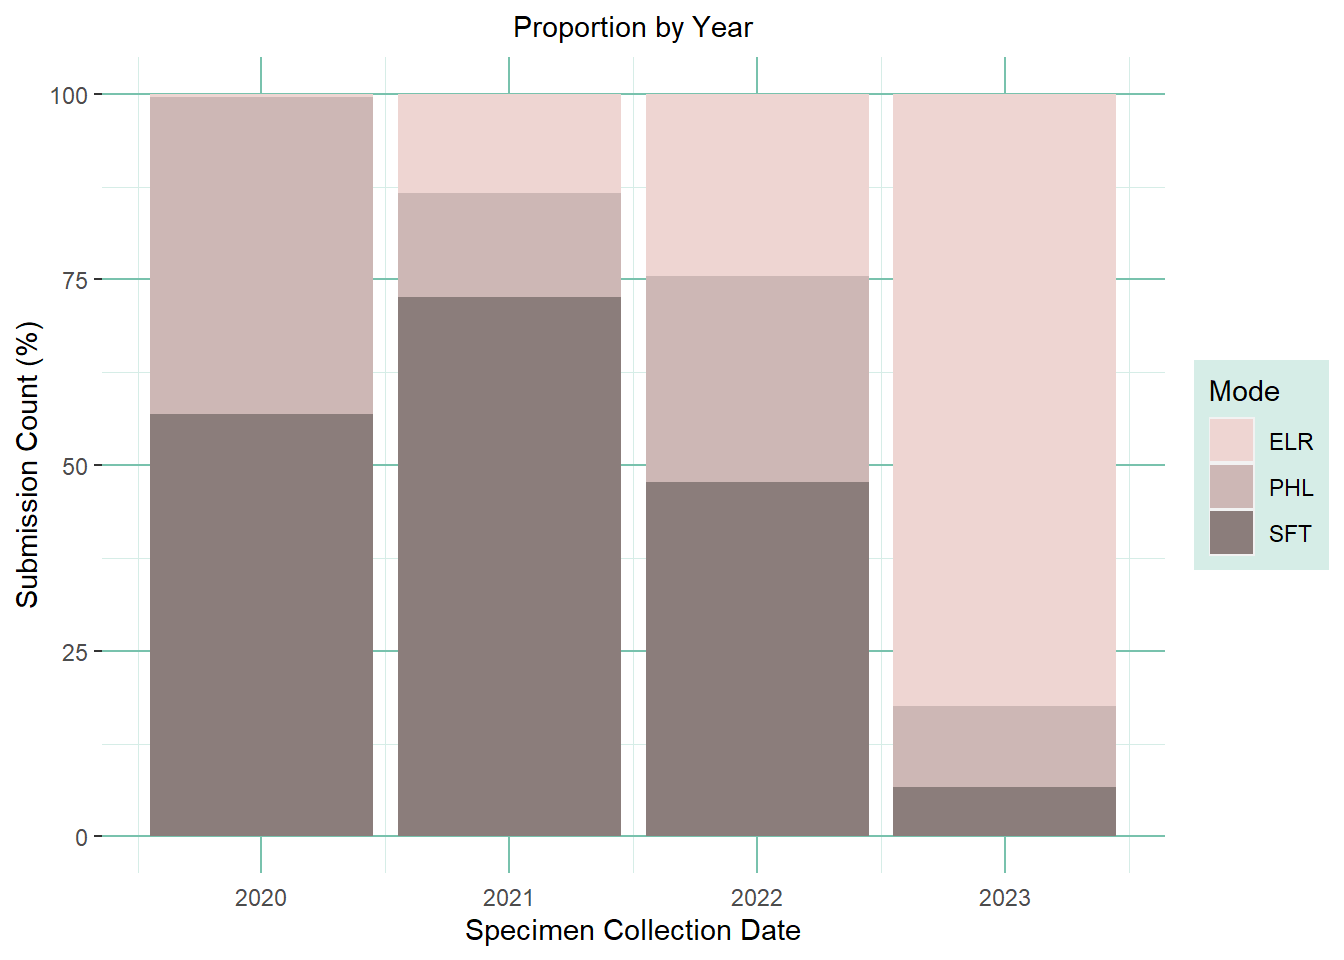

In [ ]:
library(ggplot2)


## Count Plot

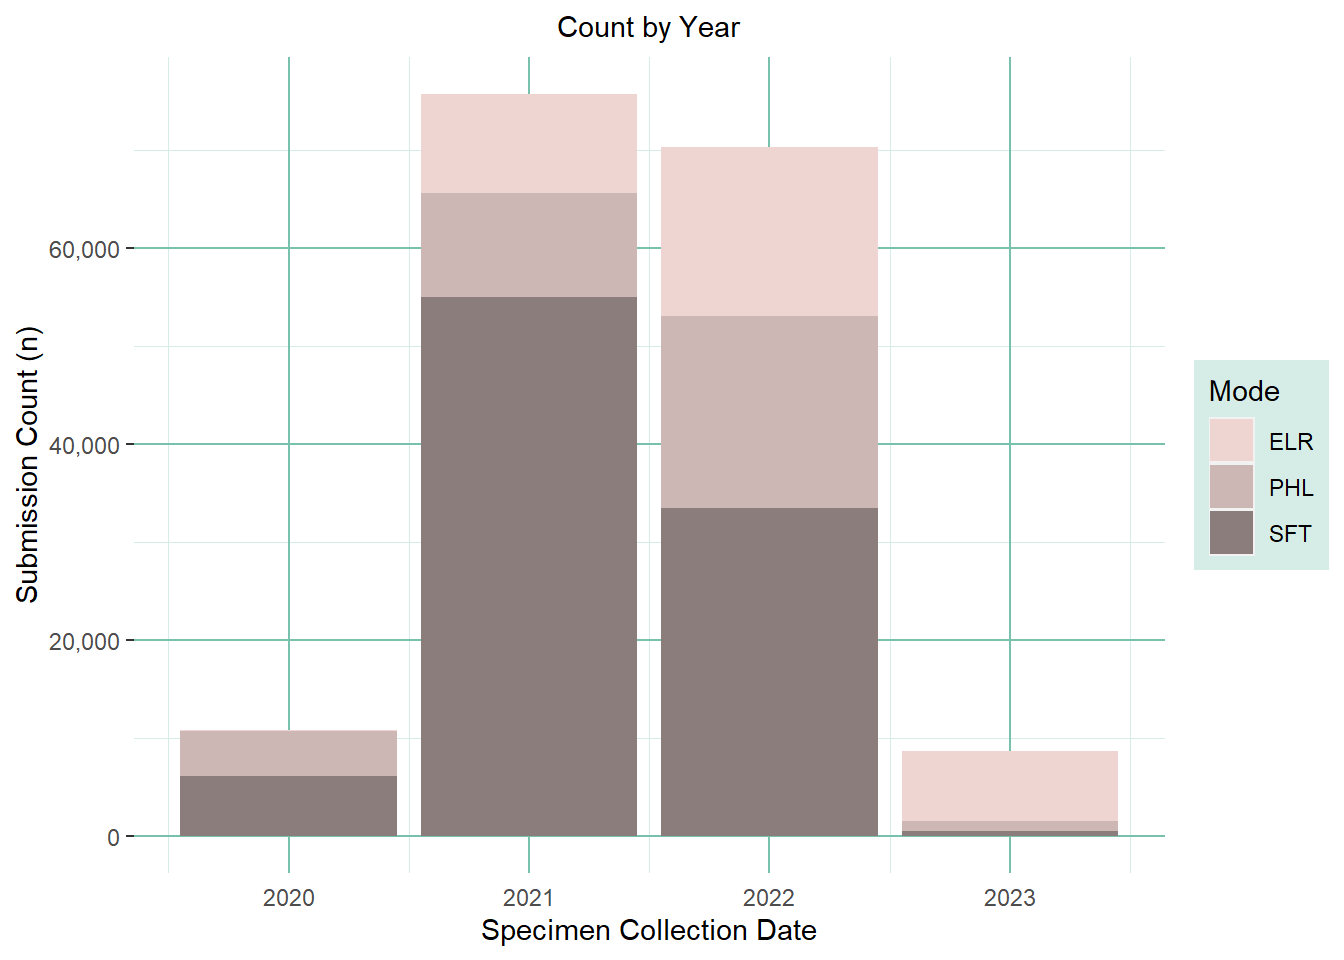

In [ ]:
### Create yearly count stacked bar: --------------------------------
(count_plot <- wdrs_seq_prep %>%
  ggplot(aes(x=sc_year, fill=submission_route)) +
  geom_bar(position='stack') +
  # scale_x_date() +
  scale_y_continuous(labels = scales::label_comma()) +
  scale_fill_manual(values=c("mistyrose2", "mistyrose3", "mistyrose4")) +
  labs(title='Count by Year',
       fill='Mode') +
  xlab('Specimen Collection Date') +
  ylab('Submission Count (n)') + 
  theme(
    plot.title = element_text(hjust = 0.5, size=rel(1)),
    axis.ticks.x = element_line(color = NA),
    panel.background = element_rect(fill = 'transparent'),
    plot.background = element_rect(fill = 'transparent', color = NA),
    panel.grid.major.y = element_line(color = '#78c2ad'),
    panel.grid.major.x = element_line(color = '#78c2ad'),
    panel.grid.minor.y = element_line(color = '#d6ede7'),
    panel.grid.minor.x = element_line(color = '#d6ede7'),
    legend.background = element_rect(fill = '#d6ede7'),
    # legend.key = element_rect(fill = 'transparent'),
    #legend.position = "none" #remove legend to save space when next to the yearly version png
  ) 
)


# Combine the plots

Use patchwork to combine the plots

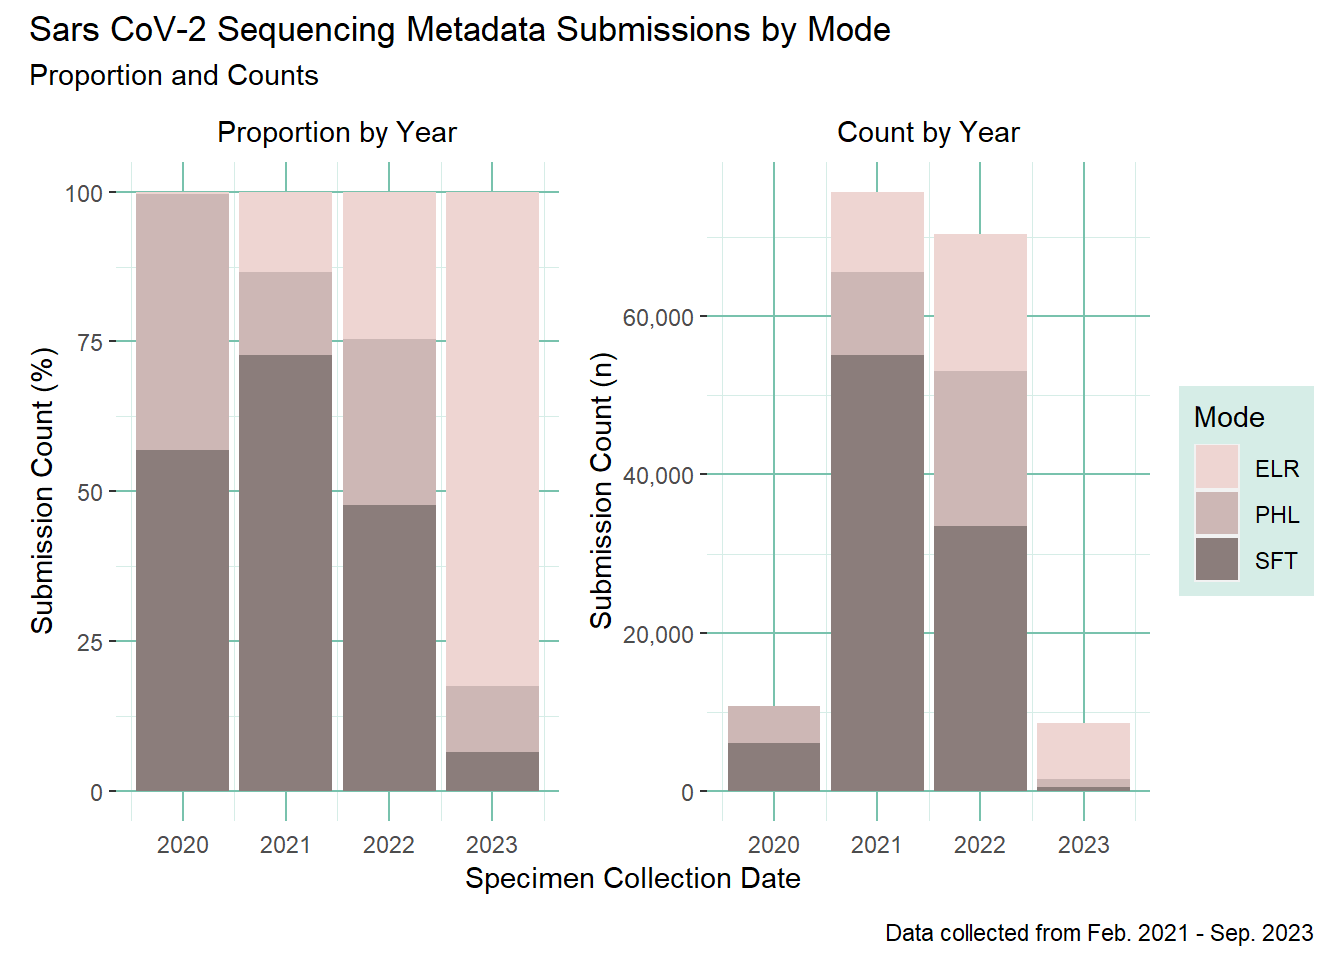

In [ ]:

library(patchwork)

(prop_plot + count_plot) + 
  plot_layout(guides="collect", axes = "collect_x") +
  plot_annotation(
    title = 'Sars CoV-2 Sequencing Metadata Submissions by Mode',
    subtitle = 'Proportion and Counts',
    caption = 'Data collected from Feb. 2021 - Sep. 2023'
  )
